# Assignment 11: Car Sales
Emily Donofrio

In [6]:
%pip install pandas xgboost scikit-learn matplotlib numpy

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/9b/35/74442388c6cf008882d4d4bdfc4109be87e9b8b7ccd097ad1e7f006e2e95/pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/af/7f/c8bde020171c900fcc808a16fe643c16d5ef96fd1516a24478bc54a428b0/xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/18/d6/ba863a4171ac9d7314c4d3fc251f015704a2caeee41ced89f321c049ed83/scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/e2/6a/d42588ad895279ff6708924645b5d2ed54a7fb2dc045c8a804e955aeace1/matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numpy

In [7]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
import os

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <B111F8D5-6AC6-3245-A6B5-94693F6992AB> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [2]:
df = pd.read_csv("monthly-car-sales.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [3]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [4]:
# confirm sorted by month

df["Month"] = pd.to_datetime(df["Month"])
df = df.sort_values("Month")

# Create lag features
for i in range (1,7):
  df[f'Sales_Lag_{i}_Month'] = df['Sales'].shift(i)

df.head(10)

,Month,Sales,Sales_Lag_1_Month,Sales_Lag_2_Month,Sales_Lag_3_Month,Sales_Lag_4_Month,Sales_Lag_5_Month,Sales_Lag_6_Month
0,1960-01-01,6550,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728,6550.0,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026,8728.0,6550.0,NaN,NaN,NaN,NaN
3,1960-04-01,14395,12026.0,8728.0,6550.0,NaN,NaN,NaN
4,1960-05-01,14587,14395.0,12026.0,8728.0,6550.0,NaN,NaN
5,1960-06-01,13791,14587.0,14395.0,12026.0,8728.0,6550.0,NaN
6,1960-07-01,9498,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
7,1960-08-01,8251,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
8,1960-09-01,7049,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
9,1960-10-01,9545,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0


In [5]:
# drop rows with null features (first 6 months)
df = df.dropna()

In [9]:
# train XGBRegressor model
y = df['Sales']
X = df.drop(['Sales', 'Month'], axis=1)

# grid search hyperparameter tuning

tscv = TimeSeriesSplit(n_splits=3)

xgb = XGBRegressor(objective="reg:squarederror")

param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1.0}
Best RMSE: 3405.451416015625


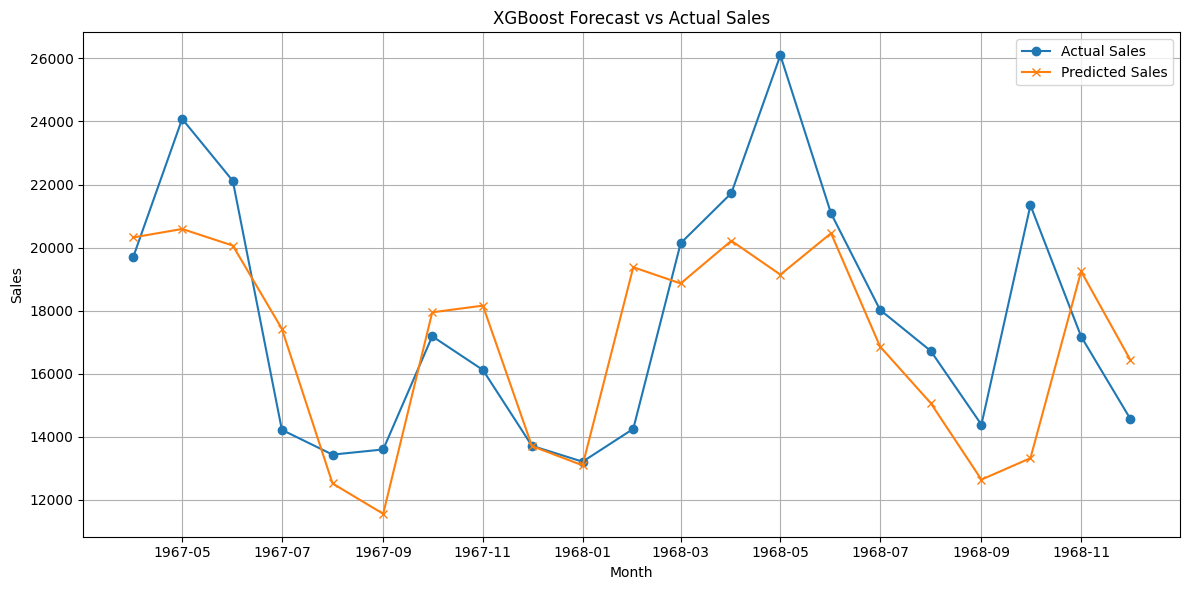

In [11]:
# plot the best model
import matplotlib.pyplot as plt
import numpy as np

# Use last 20% of data as test
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# fit best model
best_model.fit(X_train, y_train)


preds = best_model.predict(X_test)

# plot actual vs predicted
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(df["Month"].iloc[split_idx:], y_test.values,
         label="Actual Sales", marker='o')

# Plot predicted sales
plt.plot(df["Month"].iloc[split_idx:], preds,
         label="Predicted Sales", marker='x')

plt.title("XGBoost Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# train final model on all data
best_model.fit(X, y)

# save model
os.makedirs("model", exist_ok=True)
best_model.get_booster().save_model("model/model.json")

print("Model saved to model/model.json")